In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import nltk
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from nltk.stem import WordNetLemmatizer

from sklearn.preprocessing import StandardScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l1, l2, l1_l2

from statistics import mean
from sklearn import metrics
from wordcloud import WordCloud
from wordcloud import ImageColorGenerator
from wordcloud import STOPWORDS

In [12]:
df=pd.read_csv('./datasets/train.tsv', sep='\t')
df.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [4]:
df_test=pd.read_csv('./datasets/test.tsv', sep='\t')
df_test.head()

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156060 entries, 0 to 156059
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   PhraseId    156060 non-null  int64 
 1   SentenceId  156060 non-null  int64 
 2   Phrase      156060 non-null  object
 3   Sentiment   156060 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 4.8+ MB


In [16]:
df[df["SentenceId"]==1]

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2
...,...,...,...,...
58,59,1,much,2
59,60,1,of a story,2
60,61,1,a story,2
61,62,1,story,2


Looks like in this file, the sentence (review) is split into n-grams, with each n-gram parsed into a separate row with the same SentenceId and a different PhraseId

In [23]:
df["Character_Count"] = [len(x) for x in df["Phrase"]]
#Create a column with character count by Phrase, to get the longest n-gram for each Sentence Id

In [26]:
max_phrase_len = df.groupby('SentenceId')['Character_Count'].max().reset_index()

max_phrase_len.head()

In [31]:
merged_df = pd.merge(max_phrase_len,  
                      df,  
                      on =['SentenceId',"Character_Count"]) 

In [32]:
merged_df.head()

,SentenceId,Character_Count,PhraseId,Phrase,Sentiment
0,1,188,1,A series of escapades demonstrating the adage ...,1
1,2,74,64,"This quiet , introspective and entertaining in...",4
2,3,100,82,"Even fans of Ismail Merchant 's work , I suspe...",1
3,4,152,117,A positively thrilling combination of ethnogra...,3
4,5,60,157,Aggressive self-glorification and a manipulati...,1


In [133]:
merged_df.shape

(8530, 9)

## Word Counts

In [34]:
merged_df["Word_Count"] = merged_df.Phrase.apply(lambda x: len(x.split()))

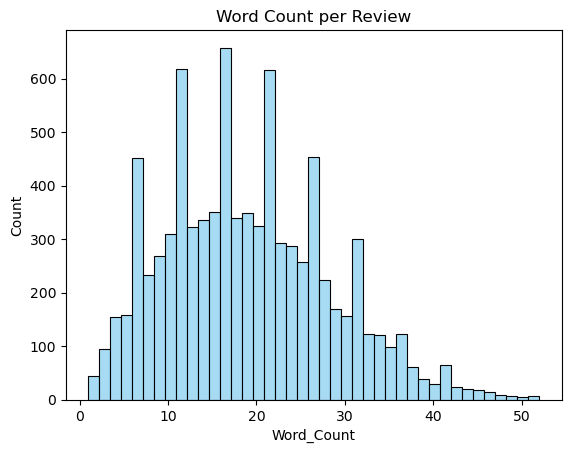

In [38]:
sns.histplot(data =merged_df['Word_Count'], color='#89CFF0').set(title='Word Count per Review');

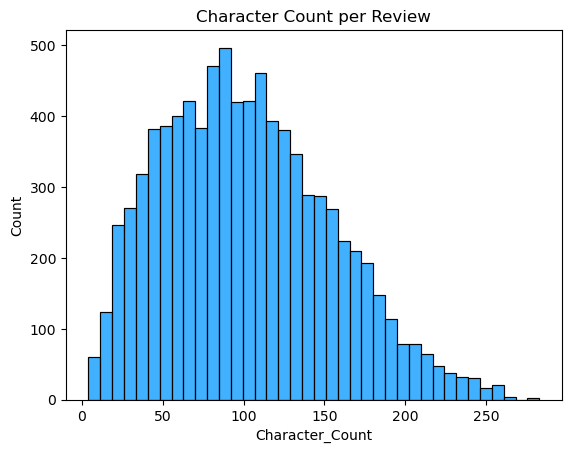

In [39]:
sns.histplot(data =merged_df['Character_Count'], color='#0096FF').set(title='Character Count per Review');

## Data Cleaning

In [61]:
# Remove blank data
merged_df["Phrase_1"] = merged_df["Phrase"].replace("\\n"," ").replace("\t"," ")

In [62]:
# Keep only alphanummeric
merged_df["Phrase_2"] = merged_df["Phrase_1"].replace("[^0-9a-zA-Z]+","")

In [9]:
# Remove stopwords
stop_words = nltk.corpus.stopwords.words('english')
new_words = [",", "' s", "'s", "' d", "'d", "' re", "'re", "' ll", "'ll", "n't", "-LRB-", '-RRB-']
stop_words.extend(new_words)

In [106]:
merged_df["Phrase_3"] = merged_df["Phrase_2"].apply(lambda words: ' '.join(word.lower() for word in words.split() if word not in stop_words))

In [12]:
import pickle

In [107]:
with open('clean_df.pkl', 'wb') as file: 

     pickle.dump(merged_df, file)

In [108]:
with open('stop_words.pkl', 'wb') as file: 

     pickle.dump(stop_words, file)

In [5]:
#do the same for Test Data
df_test["Character_Count"] = [len(x) for x in df_test["Phrase"]]
max_phrase_len_test = df_test.groupby('SentenceId')['Character_Count'].max().reset_index()
merged_df_test = pd.merge(max_phrase_len_test,  
                      df_test,  
                      on =['SentenceId',"Character_Count"]) 

In [6]:
merged_df_test["Phrase_1"] = merged_df_test["Phrase"].replace("\\n"," ").replace("\t"," ")

In [7]:
merged_df_test["Phrase_2"] = merged_df_test["Phrase_1"].replace("[^0-9a-zA-Z]+","")

In [10]:
merged_df_test["Phrase_3"] = merged_df_test["Phrase_2"].apply(lambda words: ' '.join(word.lower() for word in words.split() if word not in stop_words))

In [13]:
with open('clean_df_test.pkl', 'wb') as file: 

     pickle.dump(merged_df_test, file)

## Additional Visualizations

In [109]:
zero = " ".join(review for review in merged_df[merged_df["Sentiment"]==0].Phrase_3)
one = " ".join(review for review in merged_df[merged_df["Sentiment"]==1].Phrase_3)
two = " ".join(review for review in merged_df[merged_df["Sentiment"]==2].Phrase_3)
three = " ".join(review for review in merged_df[merged_df["Sentiment"]==3].Phrase_3)
four = " ".join(review for review in merged_df[merged_df["Sentiment"]==4].Phrase_3)

In [123]:
stopwords = set(STOPWORDS)
stopwords.update(["film", "movie", "one"])

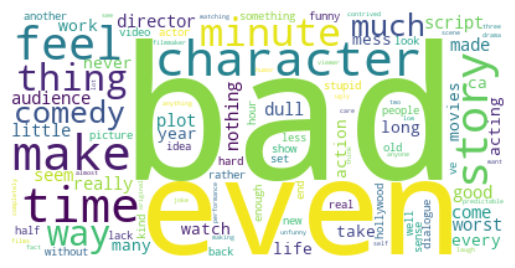

In [124]:
wordcloud = WordCloud(stopwords=stopwords, max_words=100, background_color="white").generate(zero)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show();
wordcloud.to_file("Word Cloud_Reviews_0.png");

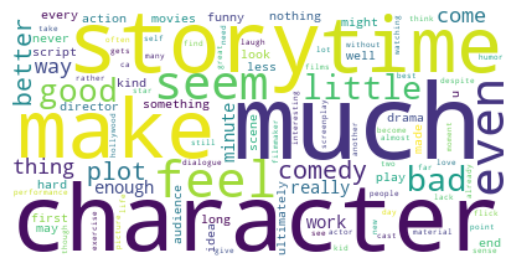

In [125]:
wordcloud = WordCloud(stopwords=stopwords, max_words=100, background_color="white").generate(one)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show();
wordcloud.to_file("Word Cloud_Reviews_1.png");

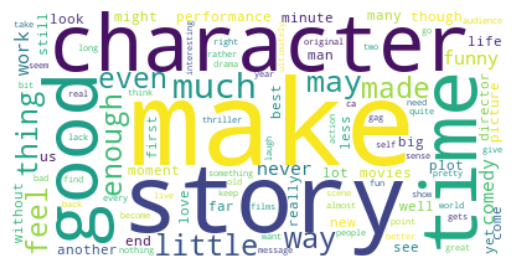

In [126]:
wordcloud = WordCloud(stopwords=stopwords, max_words=100, background_color="white").generate(two)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show();
wordcloud.to_file("Word Cloud_Reviews_2.png");

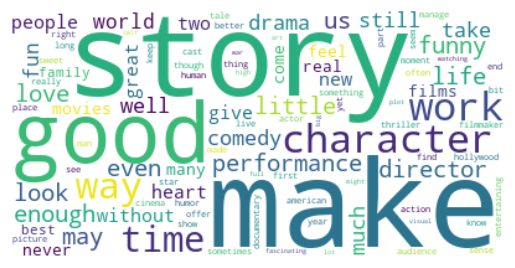

In [127]:
wordcloud = WordCloud(stopwords=stopwords, max_words=100, background_color="white").generate(three)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show();
wordcloud.to_file("Word Cloud_Reviews_3.png");

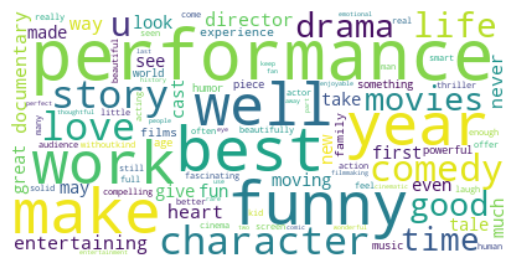

In [128]:
wordcloud = WordCloud(stopwords=stopwords, max_words=100, background_color="white").generate(four)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show();
wordcloud.to_file("Word Cloud_Reviews_4.png");

In [131]:
lemmed_reviews = merged_df["Phrase_3"]
cvec_reviews = CountVectorizer()
cvec_reviews.fit(lemmed_reviews)
cvec_lemmed_reviews = cvec_reviews.transform(lemmed_reviews)
df_for_viz = pd.DataFrame(cvec_lemmed_reviews.todense(), columns=cvec_reviews.get_feature_names_out())

ha_lemm_viz_master = pd.concat([df_for_viz, merged_df["Sentiment"]], axis=1)

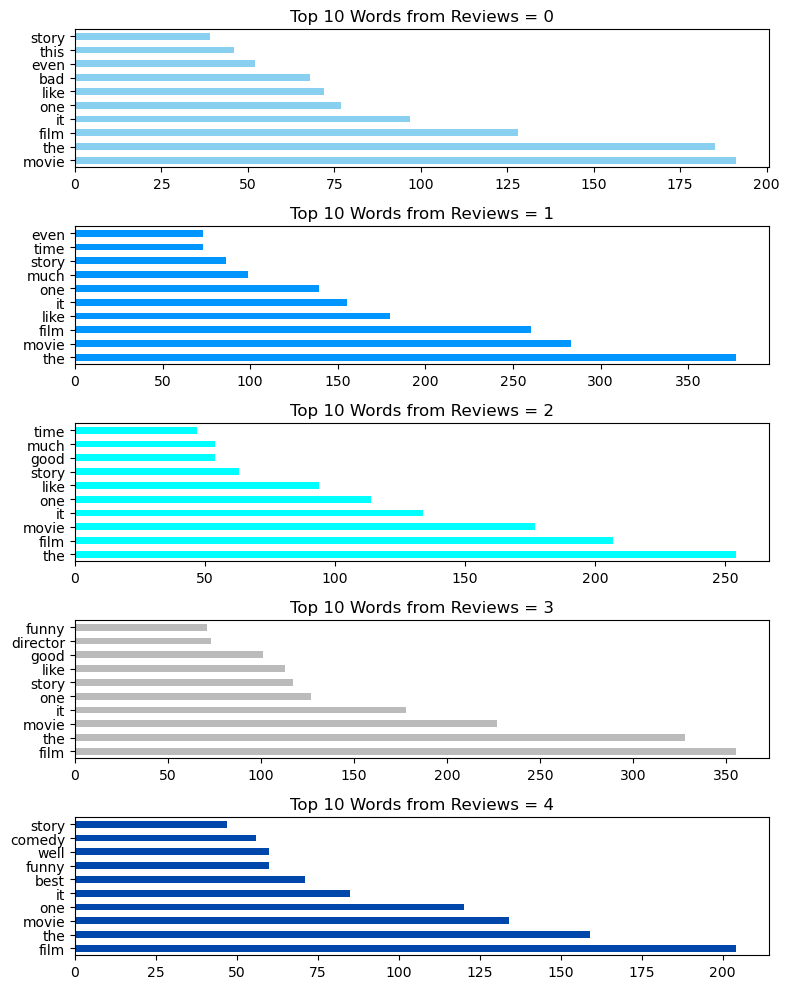

In [132]:
fig, axes = plt.subplots(5, 1, figsize=(8, 10), tight_layout=True)

(ha_lemm_viz_master[ha_lemm_viz_master["Sentiment"]==0]
    .drop(columns=['Sentiment'])
    .sum()
    .sort_values(ascending=False)
    .head(10)
    .plot(kind='barh', title='Top 10 Words from Reviews = 0', color='#89CFF0', ax=axes[0]));

(ha_lemm_viz_master[ha_lemm_viz_master["Sentiment"]==1]
    .drop(columns=['Sentiment'])
    .sum()
    .sort_values(ascending=False)
    .head(10)
    .plot(kind='barh', title='Top 10 Words from Reviews = 1', color='#0096FF', ax=axes[1]));

(ha_lemm_viz_master[ha_lemm_viz_master["Sentiment"]==2]
    .drop(columns=['Sentiment'])
    .sum()
    .sort_values(ascending=False)
    .head(10)
    .plot(kind='barh', title='Top 10 Words from Reviews = 2', color="#00FFFF", ax=axes[2]));

(ha_lemm_viz_master[ha_lemm_viz_master["Sentiment"]==3]
    .drop(columns=['Sentiment'])
    .sum()
    .sort_values(ascending=False)
    .head(10)
    .plot(kind='barh', title='Top 10 Words from Reviews = 3', color="#BCBBBB", ax=axes[3]));

(ha_lemm_viz_master[ha_lemm_viz_master["Sentiment"]==4]
    .drop(columns=['Sentiment'])
    .sum()
    .sort_values(ascending=False)
    .head(10)
    .plot(kind='barh', title='Top 10 Words from Reviews = 4', color="#0047AB", ax=axes[4]));
plt.savefig("Top Words by Review.png")
